In [3]:
# Run some setup code for this notebook.
import random
from unittest import result

import numpy as np
from utils.data_utils import *
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
# 数据集文件根路径
ROOT = 'F:\CS213n Note\cs231n_learn_pycharm\cs231n_learn\Assignment_yh/assignment_1\dataset\cifar-10-batches-py'

# 开始进行编写展示cifar10读出数组的形状
# 清除内存中已有的变量
try:
    del X_train_orgin, y_train_orgin
    del X_test_orgin, y_test_orgin
except:
    pass

X_train_origin, y_train_origin, X_test_origin, y_test_origin = load_CIFAR10(ROOT)
# debug1()

#在读取数据的函数中我们已经将数据图像矩阵进行了降维，成为了二维矩阵， 标签矩阵依旧是一维
print(X_train_origin.shape)
print(y_train_origin.shape)
print(X_test_origin.shape)
print(y_test_origin.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


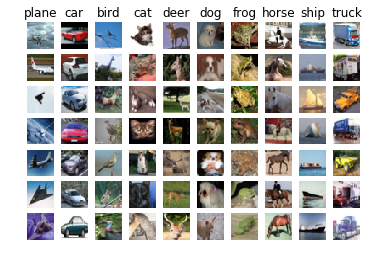

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train_origin == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train_origin[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
dict = get_CIFAR10_data(49000,1000,1000,subtract_mean=False)

X_train = dict['X_train']
y_train = dict['y_train']
X_val = dict['X_val']
y_val = dict['y_val']
X_test = dict['X_test']
y_test = dict['y_test']

# 简化训练集
num_dev = 500
mask = np.random.choice(49000, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# 对图像数据进行预处理，将（32，32，3）的图像数据拉成1维
X_train = X_train.reshape((X_train.shape[0], -1))
X_val = X_val.reshape((X_val.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))
X_dev = X_dev.reshape((X_dev.shape[0], -1))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X_dev.shape)

(49000, 3072)
(1000, 3072)
(1000, 3072)
(500, 3072)


(3072,)
[130.64189 135.98174 132.47392 130.0557  135.34804 131.75401 130.96056
 136.14328 132.47636 131.48468]


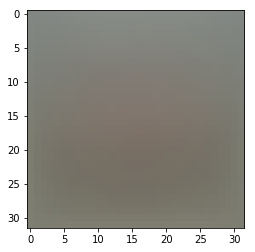

(49000, 3073)
(1000, 3073)
(1000, 3073)
(500, 3073)


In [8]:
# 进行预测前的预处理
# 图像像素减去平均值mean，用来图像图像的特征
# 同样这个功能我们我们在data_utils中实现过，axis = 0：压缩行，对各列求均值，返回1*n的矩阵
# 所以mean_image是（1×3072）的数组
mean_image = np.mean(X_train, axis=0)
print(mean_image.shape)
print(mean_image[:10])
# 可视化mean_image
# 
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32,32,3)).astype(np.uint8))
plt.show()

# 减去平均值
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image


# 在图像数据集上最后都加上一列将图像数据集变成（50000×3073）,也就是将权重与偏差融合进入W中的技巧
# 使用np.hstack()进行水平方向的堆叠
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))
X_val = np.hstack((X_val, np.ones((X_val.shape[0], 1))))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
X_dev = np.hstack((X_dev, np.ones((X_dev.shape[0], 1))))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X_dev.shape)

In [9]:
# 进行svm分类器
from classifiers.linear_svm import *
import time
# 1. 计算非向量实现svm损失的时间按
# 先随机生成参数矩阵W, 设置正则系数
W = np.random.randn(10, 3073) * 0.0001
reg = 0.000005

svm_loss, svm_grad = svm_loss_naive(W, X_dev, y_dev, reg)
print("svm_loss: &f", svm_loss)

svm_loss: &f [9.64046808]


In [10]:
# 进行svm梯度检查:将微分分析梯度与数值差值梯度作比较
from utils.gradient_check import *
# 当reg=0.0时，重新计算分析梯度
svm_loss_1, svm_grad_1 = svm_loss_naive(W, X_dev, y_dev, 0.0)
# 使用lamdba惊醒函数的映射
f = lambda W:svm_loss_naive(W, X_dev, y_dev, 0.0)[0]
grad_check_sparse(f, W, svm_grad_1)

print("增加正则梯度")
# 同样不要忘记正则梯度，在梯度计算中需要加上2*reg*W,设置reg=,也就是5，从结果可以看出分析梯度基本正确
svm_loss_2, svm_grad_2 = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda W:svm_loss_naive(W, X_dev, y_dev, 5e1)[0]
grad_check_sparse(f, W, svm_grad_2)

numerical: -5.748272 analytic: -5.748272, relative error: 1.567365e-11
numerical: 32.397515 analytic: 32.397515, relative error: 5.155668e-12
numerical: -26.853271 analytic: -26.853271, relative error: 2.258841e-11
numerical: 0.028730 analytic: 0.028730, relative error: 7.601661e-09
numerical: 2.667018 analytic: 2.667018, relative error: 6.856535e-11
numerical: 13.884607 analytic: 13.884607, relative error: 1.903730e-11
numerical: -16.421686 analytic: -16.421686, relative error: 1.096036e-11
numerical: -14.500214 analytic: -14.500214, relative error: 2.273826e-11
numerical: -21.760850 analytic: -21.760850, relative error: 1.812883e-11
numerical: 42.465601 analytic: 42.465601, relative error: 1.025090e-11
增加正则梯度
numerical: 9.080949 analytic: 9.080949, relative error: 1.994466e-11
numerical: -14.735266 analytic: -14.735266, relative error: 3.420718e-11
numerical: -12.767167 analytic: -12.767167, relative error: 1.944248e-11
numerical: -7.635893 analytic: -7.635893, relative error: 3.5941

**问题1：** 偶尔，梯度检查中的某个维度可能会不完全匹配。造成这种差异的原因是什么？是否值得担心？一个简单的例子是什么？改变边际值会如何影响发生这种情况的频率？提示：严格来说，SVM 的损失函数并不是可微分的

**回答：** 严格来说，SVM 的损失函数并不是可微分的,当处于一个转折点时，如果解析梯度与数值梯度求的分别是左右的导差别就很大


In [11]:
# 比较向量化实现的顺势计算与非向量实现的时间差异
# 非向量实现
start = time.time()
svm_loss_3, svm_grad_3 = svm_loss_naive(W, X_dev, y_dev, reg)
end = time.time()
print("非向量实现损失：%e, 程序运行时间：%fs" %(svm_loss_3, end-start))
# 向量实现
start = time.time()
svm_loss_4, svm_grad_4 = svm_loss_vectorized(W, X_dev, y_dev, reg)
end = time.time()
print("向量实现损失：%e, 程序运行时间：%fs" %(svm_loss_4, end-start))

# 两种方式计算的差异，结果看出两种实现方式毫无差异，但是向量实现的时间比非向量快得多
print("diff = %f" % (svm_loss_3 - svm_loss_4))

非向量实现损失：9.640468e+00, 程序运行时间：0.043494s
向量实现损失：9.640468e+00, 程序运行时间：0.007421s
diff = 0.000000


In [12]:
# SGD随机梯度下降,结果非常明显损失越来越小，步长为1e-7
from classifiers.linear_classifier import *
# 开始进行训练并记录时间
svm_classifier = LinearSVM()
start = time.time()
loss_history = svm_classifier.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500, verbose=True)
end = time.time()
print("训练花费时间：%f" % (end - start))

iteration 0 / 1500: loss 765722927.483125
iteration 100 / 1500: loss 280988788.446477
iteration 200 / 1500: loss 103110566.051925
iteration 300 / 1500: loss 37837238.181448
iteration 400 / 1500: loss 13884741.161321
iteration 500 / 1500: loss 5094833.798397
iteration 600 / 1500: loss 1869578.698303
iteration 700 / 1500: loss 686069.113994
iteration 800 / 1500: loss 251732.977391
iteration 900 / 1500: loss 92356.397987
iteration 1000 / 1500: loss 33879.292998
iteration 1100 / 1500: loss 12428.581586
iteration 1200 / 1500: loss 4558.486577
iteration 1300 / 1500: loss 1674.208876
iteration 1400 / 1500: loss 617.035634
训练花费时间：6.510098


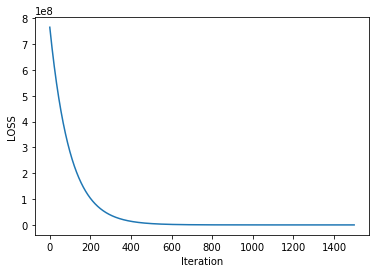

In [13]:
# 可视化SGD损失的下降趋势，理解更深刻,非常明显的下降过程
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('LOSS')
plt.show()


In [14]:
# 验证预测功能，现在训练集上再在验证集上，并计算准确率
# 训练集
y_pred_1 = svm_classifier.predict(X_train)
acc_1 = np.mean((y_train == y_pred_1))
print("在训练集上，预测准确率为%f" % (acc_1))

# 验证集
y_pred_2 = svm_classifier.predict(X_val)
acc_2 = np.mean((y_pred_2 == y_val))
print("在验证集上，预测准确率为%f" % (acc_2))
# 结果可以看出正确率还不是很高，所以要优化参数：学习率与正则惩罚等

在训练集上，预测准确率为0.261469
在验证集上，预测准确率为0.261000


In [15]:
"""
调参环节，从不同的 learning rate 与 regularization strengths 中选出使验证集正确率最高的组合。对每一种组合都训一遍 SVM，然后计算一次正确率。
不过在 learning rate 较大的两个情况训练时，发生了计算溢出的情况。题面中说这是正常现象，正确率接近39%就算成功。
"""
# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1 # 此变量用来存储最高的验证集准确率
best_svm = None # 此变量用来存储最好的svm分类器对象

# 参考参数
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

for lr in learning_rates:
    for reg in regularization_strengths:
        print("此时组合(学习率：%e, 正则系数：%e)" % (lr, reg))
        key = (lr, reg)
        svm_classifier_1 = LinearSVM()
        loss_history = svm_classifier_1.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
        y_pred_train = svm_classifier_1.predict(X_train)
        y_pred_val = svm_classifier_1.predict(X_val)
        acc_train = np.mean((y_train == y_pred_train))
        acc_val = np.mean((y_pred_val == y_val))
        results[key] = (acc_train, acc_val)
        if acc_val > best_val:
            best_val = acc_val
            best_svm = svm_classifier_1

print("Best")
# 输出字典内容,对字典的key进行排序
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    
    
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

此时组合(学习率：1.000000e-07, 正则系数：2.500000e+04)
此时组合(学习率：1.000000e-07, 正则系数：5.000000e+04)
此时组合(学习率：5.000000e-05, 正则系数：2.500000e+04)


F:\CS213n Note\cs231n_learn_pycharm\cs231n_learn\Assignment_yh\assignment_1\classifiers\linear_svm.py:119: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
E:\Anaconda\envs\cs231n\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
F:\CS213n Note\cs231n_learn_pycharm\cs231n_learn\Assignment_yh\assignment_1\classifiers\linear_svm.py:119: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


此时组合(学习率：5.000000e-05, 正则系数：5.000000e+04)


E:\Anaconda\envs\cs231n\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
F:\CS213n Note\cs231n_learn_pycharm\cs231n_learn\Assignment_yh\assignment_1\classifiers\linear_svm.py:126: RuntimeWarning: overflow encountered in multiply
  dW = counts.T.dot(X)/num_train + 2 * reg * W
F:\CS213n Note\cs231n_learn_pycharm\cs231n_learn\Assignment_yh\assignment_1\classifiers\linear_classifier.py:54: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


Best
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.260857 val accuracy: 0.266000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.360469 val accuracy: 0.373000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.108571 val accuracy: 0.125000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.373000


{(1e-07, 25000.0): (0.26085714285714284, 0.266), (1e-07, 50000.0): (0.36046938775510207, 0.373), (5e-05, 25000.0): (0.10857142857142857, 0.125), (5e-05, 50000.0): (0.10026530612244898, 0.087)}


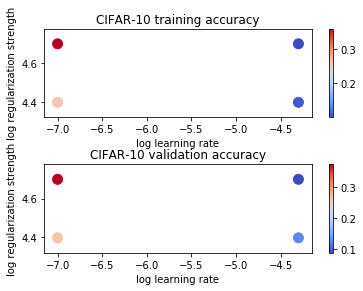

In [18]:
# 可视化交叉验证结果i
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# 输出字典
print(results)

# 绘制散点图，横坐标为学习率，纵坐标为正则系数，颜色代表精确度大小
# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm, )
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [17]:
# 在测试集上进行预测
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.365000


(10, 3072)


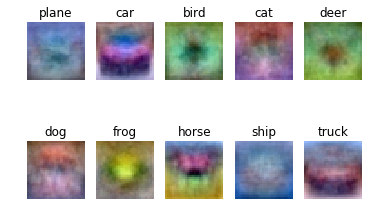

In [36]:
# 我们知道最终得到best_svm,其中同样有最好的W，W的形状是(C×(D+1))带上一列偏差
# 所以W的每一行是一张图片
w = best_svm.W[:, :-1] # (10×3072)
print(w.shape)
w = w.reshape(10, 32, 32, 3)
# 使用max与min逐位进行比较，找到w中的最大最小值
max_w = np.max(w)
min_w = np.min(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for y ,cls in enumerate(classes):
    id = i+1
    plt.subplot(2, 5, y+1)
    # w中的值归一化再乘以255
    wimg = 255.0 * ((w[y] - min_w) / (max_w - min_w))
    plt.imshow(wimg.astype(np.uint8))
    plt.axis('off')
    plt.title(cls)
plt.show()